In [ ]:
# Importing datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

#### **Task 1: Loading and preprocessing the dataset**

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 52.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.2MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.72MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
x_train, y_train = dataset.data.numpy(), dataset.targets.numpy()
x_test, y_test = test_dataset.data.numpy(), test_dataset.targets.numpy()

In [ ]:
x_train = x_train.reshape(-1, 28 * 28) / 255.0
x_test = x_test.reshape(-1, 28 * 28) / 255.0

#### **Task 2: Defining the RBM**

In [ ]:
class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(visible_units, hidden_units) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(hidden_units))
        self.v_bias = nn.Parameter(torch.zeros(visible_units))

    def forward(self, v):
        h_prob = torch.sigmoid(torch.matmul(v, self.W) + self.h_bias)
        h_sample = torch.bernoulli(h_prob)
        return h_prob, h_sample

    def backward(self, h):
        v_prob = torch.sigmoid(torch.matmul(h, self.W.t()) + self.v_bias)
        v_sample = torch.bernoulli(v_prob)
        return v_prob, v_sample

    def free_energy(self, v):
        vbias_term = torch.matmul(v, self.v_bias)
        hidden_term = torch.sum(torch.log(1 + torch.exp(torch.matmul(v, self.W) + self.h_bias)), dim=1)
        return -vbias_term - hidden_term

In [ ]:
# Initializing RBM
visible_units = 28 * 28
hidden_units = 128
rbm = RBM(visible_units, hidden_units)
optimizer = optim.SGD(rbm.parameters(), lr=0.01)

In [ ]:
# Training RBM
epochs = 50
batch_size = 64
train_data = torch.tensor(x_train, dtype=torch.float32)

for epoch in range(epochs):
    epoch_loss = 0
    for i in range(0, len(train_data), batch_size):
        batch = train_data[i:i+batch_size]
        v0 = batch
        h_prob, h_sample = rbm.forward(v0)
        v_prob, v_sample = rbm.backward(h_sample)

        loss = torch.mean(rbm.free_energy(v0) - rbm.free_energy(v_prob))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/50, Loss: -169390.0815
Epoch 2/50, Loss: -169889.5801
Epoch 3/50, Loss: -170298.7358
Epoch 4/50, Loss: -170655.1295
Epoch 5/50, Loss: -170975.6322
Epoch 6/50, Loss: -171266.9633
Epoch 7/50, Loss: -171523.8077
Epoch 8/50, Loss: -171749.8174
Epoch 9/50, Loss: -171953.0494
Epoch 10/50, Loss: -172120.5948
Epoch 11/50, Loss: -172265.7619
Epoch 12/50, Loss: -172415.9013
Epoch 13/50, Loss: -172557.8728
Epoch 14/50, Loss: -172680.3294
Epoch 15/50, Loss: -172782.8799
Epoch 16/50, Loss: -172902.7679
Epoch 17/50, Loss: -172989.4841
Epoch 18/50, Loss: -173045.8194
Epoch 19/50, Loss: -173121.3240
Epoch 20/50, Loss: -173204.5628
Epoch 21/50, Loss: -173276.4798
Epoch 22/50, Loss: -173341.9573
Epoch 23/50, Loss: -173390.6331
Epoch 24/50, Loss: -173447.7654
Epoch 25/50, Loss: -173495.5814
Epoch 26/50, Loss: -173556.1113
Epoch 27/50, Loss: -173587.0955
Epoch 28/50, Loss: -173633.8551
Epoch 29/50, Loss: -173654.5704
Epoch 30/50, Loss: -173687.6646
Epoch 31/50, Loss: -173697.6106
Epoch 32/50, Loss

#### **Task 3: Extracting hidden representations**

In [ ]:
train_hidden_features = rbm.forward(torch.tensor(x_train, dtype=torch.float32))[0].detach().numpy()
test_hidden_features = rbm.forward(torch.tensor(x_test, dtype=torch.float32))[0].detach().numpy()

np.save("train_hidden_features.npy", train_hidden_features)
np.save("test_hidden_features.npy", test_hidden_features)

#### **Task 4: Visualizing RBM weights**

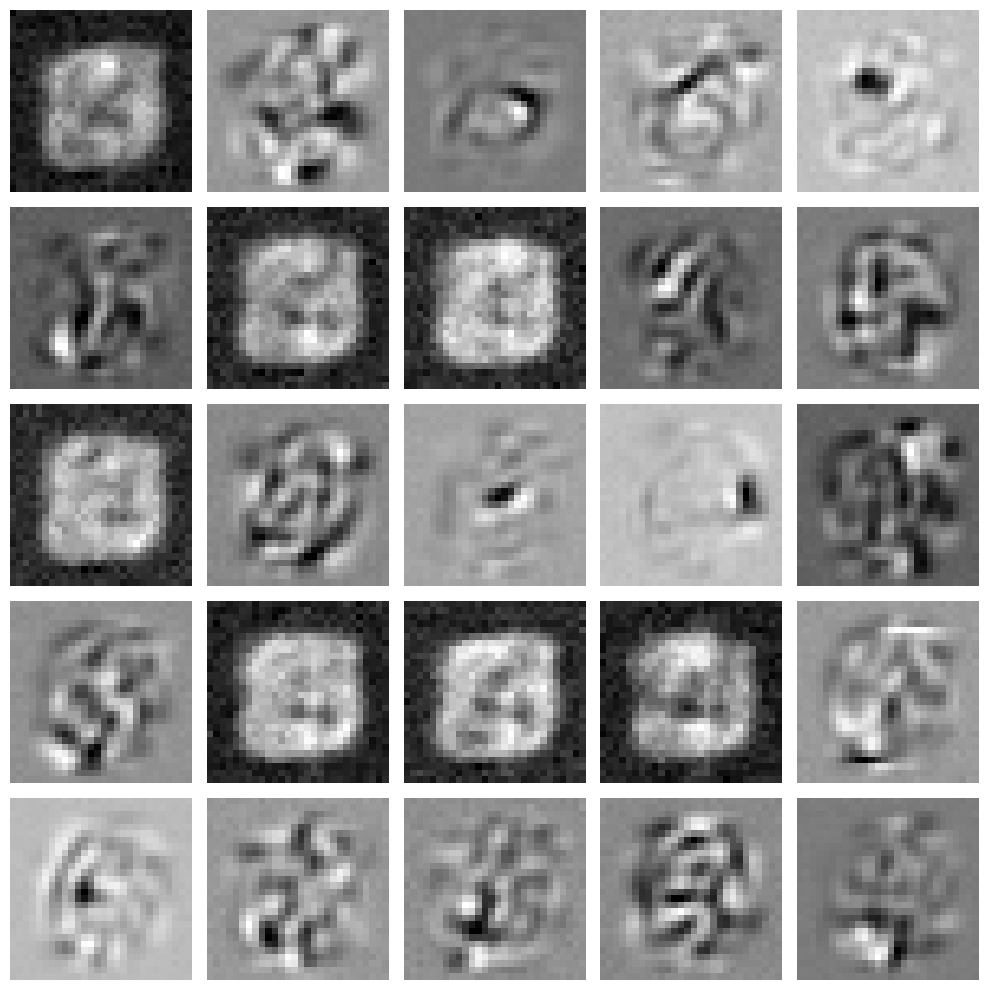

In [ ]:
def visualize_weights(rbm, num_images=25, grid_size=(5, 5)):
    weights = rbm.W.detach().numpy().T
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            img = weights[i].reshape(28, 28)
            ax.imshow(img, cmap="gray")
            ax.axis("off")
        else:
            ax.axis("off")
    plt.tight_layout()
    plt.show()

visualize_weights(rbm, num_images=25, grid_size=(5, 5))

#### **Task 5: Training classifier on RBM features**

In [ ]:
classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(train_hidden_features, y_train)
y_pred = classifier.predict(test_hidden_features)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

In [ ]:
print("Performance with RBM Features:")
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Performance with RBM Features:
Accuracy: 0.9351
F1 Score: 0.935048935071287

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       980
           1       0.97      0.98      0.98      1135
           2       0.93      0.93      0.93      1032
           3       0.92      0.93      0.93      1010
           4       0.93      0.93      0.93       982
           5       0.92      0.91      0.92       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.91      0.91      0.91       974
           9       0.91      0.91      0.91      1009

    accuracy                           0.94     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.94      0.94      0.94     10000



#### **Task 6: Comparing with raw pixel data**

In [ ]:
classifier_raw = LogisticRegression(max_iter=1000, random_state=42)
classifier_raw.fit(x_train, y_train)
y_pred_raw = classifier_raw.predict(x_test)

accuracy_raw = accuracy_score(y_test, y_pred_raw)
f1_raw = f1_score(y_test, y_pred_raw, average="weighted")

In [ ]:
print("Performance Comparison of RBM Features vs. Raw Pixels:")
print(f"Accuracy with RBM Features: {accuracy:.4f}")
print(f"Accuracy with Raw Pixels: {accuracy_raw:.4f}")
print(f"F1-Score with RBM Features: {f1:.4f}")
print(f"F1-Score with Raw Pixels: {f1_raw:.4f}")

Performance Comparison of RBM Features vs. Raw Pixels:
Accuracy with RBM Features: 0.9351
Accuracy with Raw Pixels: 0.9258
F1-Score with RBM Features: 0.9350
F1-Score with Raw Pixels: 0.9256
